In [542]:
import pandas as pd
import numpy as np

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

import string
import math
import re
from collections import Counter

In [544]:
ls

onlineHarassmentDataset.tdf  README  Terms of Use.pdf


In [546]:
cd /srv/toxic_online_datasets/UMD_Twitter_Online_Harassment_Dataset

/srv/toxic_online_datasets/UMD_Twitter_Online_Harassment_Dataset


In [548]:
ls

onlineHarassmentDataset.tdf  README  Terms of Use.pdf


In [550]:
dataset = open('onlineHarassmentDataset.tdf', 'r')
data = pd.read_csv('onlineHarassmentDataset.tdf', delimiter='\t', encoding='latin-1')

In [552]:
print(data[0:50])

    ID Code                                              Tweet  Unnamed: 3  \
0    1    H  @Grumpy_P_Sloth @deanesmay feminists argue for...         NaN   
1    2    H  1948Army of England helped the Jews to occupy ...         NaN   
2    3    H  Dutch Leader Says Europe to collapse In 6 Week...         NaN   
3    4    H  RT @__DeLay: The next day the Romans and the J...         NaN   
4    5    H  RT @Bakersman_Joe: When Hitler Invited The Jew...         NaN   
5    6    H  RT @billmaher: Bravo to #Netanyahu for his 45 ...         NaN   
6    7    H  RT @BitchImKermit: White people literally Be l...         NaN   
7    8    H  RT @CharlesFinch: "The Jews were provided free...         NaN   
8    9    H  RT @gofran942010: "I would have killed all the...         NaN   
9   10    H  RT @HeymanHustle: .. @MichelleDBeadle I can do...         NaN   
10  11    H  RT @HSConfessionaI: "Did a PowerPoint on 9 /11...         NaN   
11  12    H  .@ExqCreations Who...the Jews?  They run the s...  

In [554]:
# return just harassing, just nonharassing, or all tweets

def getCodedTweets(data, code=None):
    if code == None:
        return data[['Code', 'Tweet']]
    else:
        return data.loc[data['Code'] == code, ['Code', 'Tweet']]

In [556]:
# return cleaned Tweet as string
# remove stopwords, user handles, punctuation, urls
# keep 'rt' and 'via'

def cleanTweets(tweet):
    tt = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)

    punctuation = list(string.punctuation)
    
    # strip stopwords, punctuation, url components 
    stop = stopwords.words('english') + punctuation + ['t.co', 'http', 'https', '...', '..', ':\\']

    strip_nums = re.sub("\d+", "", tweet)
    tokenized = tt.tokenize(strip_nums)
    terms_stop = [term for term in tokenized if term not in stop]
    cleaned = [term for term in terms_stop]
    #cleaned = ' '.join(cleaned)
    
    return cleaned

In [558]:
# calculate word frequencies for all tweets, just harassing, or just nonharassing
# if just harassing / nonharassing, append 'Code' column to df

def calcWordFreq(data, code=None):
    tweets = getCodedTweets(data, code)      
    tweets['Tweet'] = tweets['Tweet'].map(cleanTweets)
    
    counter = Counter()
    
    #freq = pd.Series(' '.join(tweets.Tweet).split()).value_counts()
    tweets['Tweet'].map(counter.update)
    freq = pd.DataFrame.from_dict(counter, orient='index').reset_index()
    freq = freq.rename(columns= {'index': 'Word', 0:'Frequency'})
    freq = freq.sort_values('Frequency', ascending=False)
    
    if code == 'H' or code == 'N':
        freq['Code'] = code
    
    return freq

In [560]:
all_freq = calcWordFreq(data)
print(all_freq.head())

                 Word  Frequency
22437            jews      10216
23018              rt       6778
20435  #whitegenocide       2562
15954         fucking       2053
30725           white       1272


/usr/lib/python3.4/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [562]:
harassing_freq = calcWordFreq(data, 'H')
print(harassing_freq.head())

                 Word  Frequency Code
4821             jews       2499    H
7006               rt       1757    H
12114         fucking        708    H
3256   #whitegenocide        679    H
11123           white        417    H


In [564]:
nonharassing_freq = calcWordFreq(data, 'N')
print(nonharassing_freq.head())

                 Word  Frequency Code
18830            jews       7717    N
7712               rt       5021    N
17139  #whitegenocide       1883    N
26014         fucking       1345    N
20867            like        864    N


In [566]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [568]:
# graph 20 most common words 

def word_freq_chart(frequencies):
    source = frequencies.head(20)

    chart = alt.Chart(source).mark_bar().encode(
        x = alt.Y(
            'Word',
            sort = alt.EncodingSortField(
                field = 'Frequency',
                op = 'values',
                order = 'ascending'
            )        
        ),
        y = 'Frequency'
    )
    
    return chart

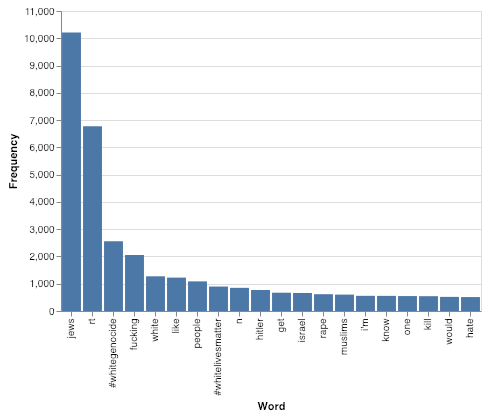

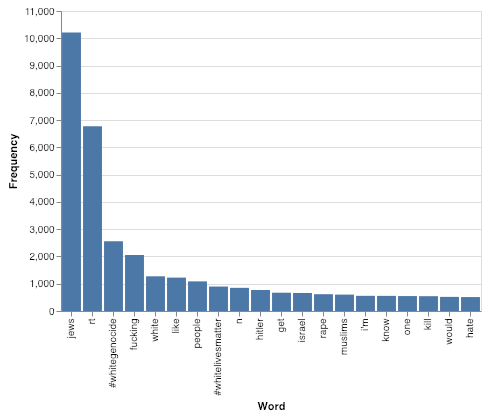

In [570]:
word_freq_chart(all_freq)

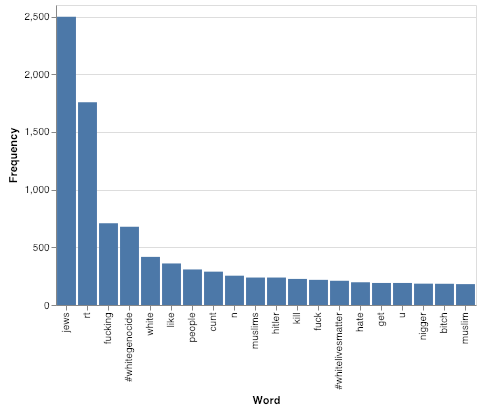

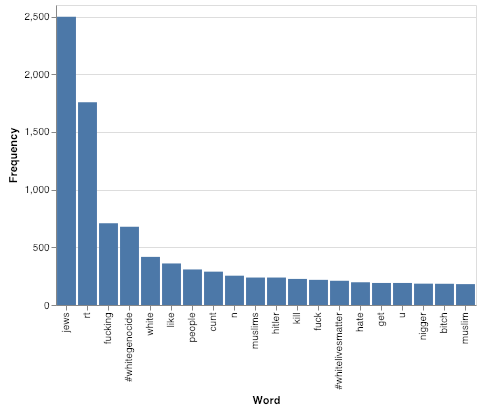

In [572]:
word_freq_chart(harassing_freq)

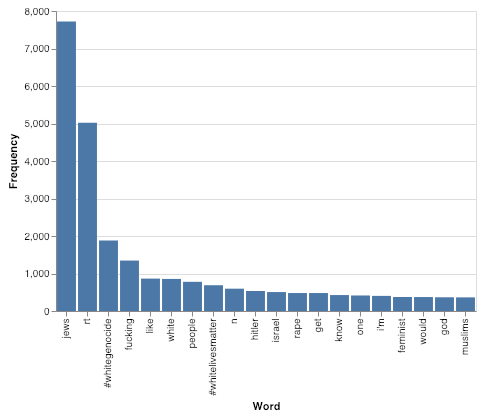

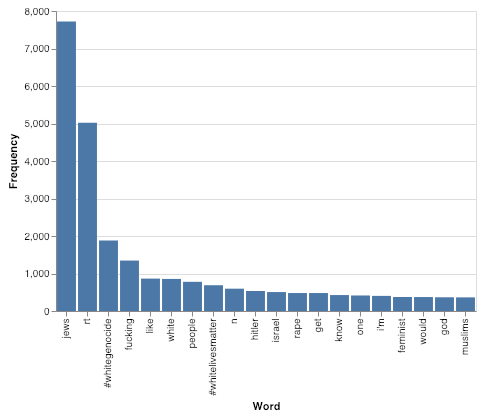

In [574]:
word_freq_chart(nonharassing_freq)

In [576]:
def grouped_freq_chart(combined_df):
    source = combined_df

    chart = alt.Chart(source).mark_bar().encode(
        x = 'Code',
        y = 'Frequency',
        color = 'Code',
        column = 'Word'
    )
    
    return chart

In [578]:
top_ten = all_freq.head(10)

combined_df = []

for i in top_ten['Word']:
    combined_df.append(nonharassing_freq.loc[nonharassing_freq['Word'] == i])
    combined_df.append(harassing_freq.loc[harassing_freq['Word'] == i])


combined_df = pd.concat(combined_df)
print(combined_df)

                    Word  Frequency Code
18830               jews       7717    N
4821                jews       2499    H
7712                  rt       5021    N
7006                  rt       1757    H
17139     #whitegenocide       1883    N
3256      #whitegenocide        679    H
26014            fucking       1345    N
12114            fucking        708    H
25848              white        855    N
11123              white        417    H
20867               like        864    N
6683                like        360    H
3810              people        778    N
3418              people        308    H
23891  #whitelivesmatter        687    N
7183   #whitelivesmatter        210    H
18563                  n        595    N
4550                   n        254    H
25969             hitler        533    N
11239             hitler        238    H


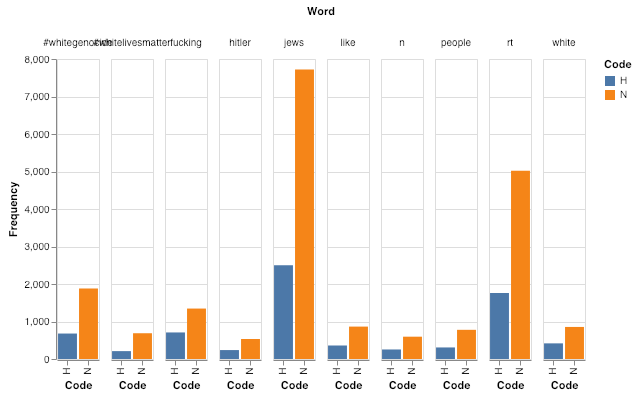

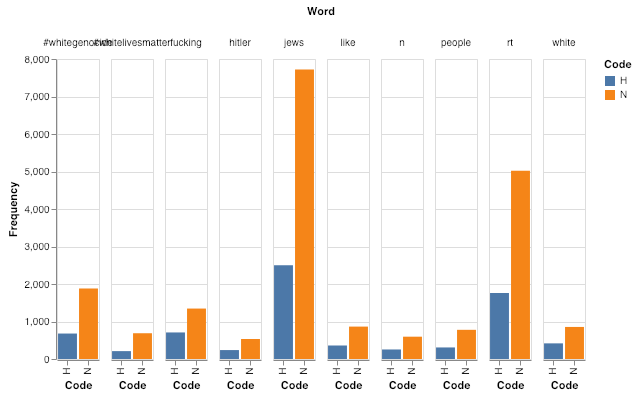

In [580]:
grouped_freq_chart(combined_df)

In [582]:
harassing_freq['tf'] = np.nan
harassing_freq['df'] = np.nan
harassing_freq['tf_idf'] = np.nan

harassing_total = harassing_freq['Frequency'].sum()

for index, row in harassing_freq.iterrows():  
    if harassing_freq.loc[index, 'Word'] in nonharassing_freq['Word'].values:
        df = 2
        harassing_freq.loc[index, 'df'] = 2
    else:
        df = 1
        harassing_freq.loc[index, 'df'] = 1
        
    tf = harassing_freq.loc[index, 'Frequency']/harassing_total
    harassing_freq.loc[index, 'tf'] = tf
    
    harassing_freq.loc[index, 'tf_idf'] = tf*math.log(2/df)        

In [584]:
print(harassing_freq.sort_values('tf_idf', ascending=False))

                                                    Word  Frequency Code  \
8655                                        #familycourt         15    H   
4997                                               #cunt         15    H   
2213                                #wrongfullyconvicted         14    H   
6357                                         #alienation         11    H   
7025                                           worthless         10    H   
3053                            #endviolenceagainstwomen          9    H   
4171                                                   ®          7    H   
9473                                                daft          6    H   
4367                                               hairy          6    H   
3066   #whitelivesmatterbuttheyrenottheonesbeingkille...          5    H   
9118                                             zpcwrzd          5    H   
7198                                             spoiled          5    H   
6861        

In [586]:
nonharassing_freq['tf'] = np.nan
nonharassing_freq['df'] = np.nan
nonharassing_freq['tf_idf'] = np.nan

nonharassing_total = nonharassing_freq['Frequency'].sum()

for index, row in nonharassing_freq.iterrows():  
    if nonharassing_freq.loc[index, 'Word'] in harassing_freq['Word'].values:
        df = 2
        nonharassing_freq.loc[index, 'df'] = 2
    else:
        df = 1
        nonharassing_freq.loc[index, 'df'] = 1
        
    tf = nonharassing_freq.loc[index, 'Frequency']/nonharassing_total
    nonharassing_freq.loc[index, 'tf'] = tf
    
    nonharassing_freq.loc[index, 'tf_idf'] = tf*math.log(2/df) 

In [ ]:
print(nonharassing_freq.sort_values('tf_idf', ascending=False))

In [ ]:
print('Harassing total: ', harassing_total)
print('\nNonharassing total: ', nonharassing_total)

In [ ]:
tweets = getCodedTweets(data, 'H')
tweets['Tweet'] = tweets['Tweet'].map(cleanTweets)

In [ ]:
tweets['Tweet'] = tweets.apply(lambda row: list(nltk.bigrams(row['Tweet'])), axis=1)
print(tweets.head())

In [588]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [589]:
v = TfidfVectorizer()

In [591]:
x = v.fit_transform(data['Tweet'])

/usr/lib64/python3.4/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [592]:
x.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [593]:
print(x.shape)

(20360, 44879)


In [595]:
idf = v.idf_
print(dict(zip(v.get_feature_names(), idf)))

{'europeans': 7.7433227550239225, 'killer': 8.618791492377822, 'ameer_tsidi': 10.228229404811923, 'robothugscomic': 10.228229404811923, 'harasses': 10.228229404811923, 'fawzaan': 9.822764296703758, 'accountability': 10.228229404811923, 'sachahodges_': 10.228229404811923, '3ljyhljruf': 10.228229404811923, 'endlessly': 10.228229404811923, 'region': 8.213326384269658, 'hinduism': 9.822764296703758, 'removes': 9.822764296703758, 'hollywood': 7.925644311817877, 'qbaé': 10.228229404811923, 'heartless': 9.822764296703758, 'hermit_hwarang': 10.228229404811923, 'txjrhfragz': 10.228229404811923, 'ronaldos': 10.228229404811923, 'j0cye2hidj': 10.228229404811923, 'indig': 10.228229404811923, 'aggad': 10.228229404811923, 'saasyrzo4x': 10.228229404811923, 'profound_info': 10.228229404811923, 'kbfvgss4na': 10.228229404811923, 'linnykravtiz': 10.228229404811923, 'osaz112': 10.228229404811923, 'u3qr0ihypk': 10.228229404811923, 'fml8ffkqxi': 10.228229404811923, 'receiving': 9.535082224251978, 'valhallasa

In [ ]:
# fit on entire dataset, transform on harassing vs nonharassing corpuses 

In [1]:
# elmo, bert?